<a href="https://colab.research.google.com/github/AnshLoomba045009/anshloomba045009/blob/main/045009IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from requests import get
from time import sleep
from random import randint
from bs4 import BeautifulSoup
from warnings import warn


# Note this takes about 40 min to run if np.arange is set to 9951 as the stopping point.

pages = np.arange(1, 9951, 50) # Last time I tried, I could only go to 10000 items because after that the URI has no discernable pattern to combat webcrawlers; I just did 4 pages for demonstration purposes. You can increase this for your own projects.
headers = {'Accept-Language': 'en-US,en;q=0.8'} # If this is not specified, the default language is Mandarin

#initialize empty lists to store the variables scraped
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

for page in pages:

   #get request for sci-fi
   response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                  + "start="
                  + str(page)
                  + "&explore=title_type,genres&ref_=adv_prv", headers=headers)

   sleep(randint(8, 15))

   #throw warning for status codes that are not 200
   if response.status_code != 200:
       warn('Request: {}; Status code: {}'.format(requests, response.status_code))

   #parse the content of the current iteration of the request
   page_html = BeautifulSoup(response.text, 'html.parser')

   movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

   if not movie_containers:
       # If no movie containers are found, you can break the loop or handle it accordingly.
       break

   #extract the 50 movies for that page
   for container in movie_containers:
       #conditional for all with metascore
       if container.find('div', class_ = 'ratings-metascore') is not None:

           #title
           title = container.h3.a.text
           titles.append(title)

           if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:

             #year released
             year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text # remove the parentheses around the year and make it an integer
             years.append(year)

           else:
             years.append(None) # each of the additional if clauses are to handle type None data, replacing it with an empty string so the arrays are of the same length at the end of the scraping

           if container.p.find('span', class_ = 'certificate') is not None:

             #rating
             rating = container.p.find('span', class_= 'certificate').text
             ratings.append(rating)

           else:
             ratings.append("")

           if container.p.find('span', class_ = 'genre') is not None:

             #genre
             genre = container.p.find('span', class_= 'genre').text.replace("\n", "").rstrip().split(',') # remove the whitespace character, strip, and split to create an array of genres
             genres.append(genre)

           else:
             genres.append("")

           if container.p.find('span', class_ = 'runtime') is not None:

             #runtime
             time = int(container.p.find('span', class_= 'runtime').text.replace(" min", "")) # remove the minute word from the runtime and make it an integer
             runtimes.append(time)

           else:
             runtimes.append(None)

           if float(container.strong.text) is not None:

             #IMDB ratings
             imdb = float(container.strong.text) # non-standardized variable
             imdb_ratings.append(imdb)

           else:
             imdb_ratings.append(None)

           if container.find('span', class_ = 'metascore').text is not None:

             #Metascore
             m_score = int(container.find('span', class_ = 'metascore').text) # make it an integer
             metascores.append(m_score)

           else:
             metascores.append(None)

           if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:

             #Number of votes
             vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
             votes.append(vote)

           else:
               votes.append(None)


In [6]:
import pandas as pd

# Assuming you have already scraped the data and created the following lists
# titles, years, ratings, genres, runtimes, imdb_ratings, metascores, votes

sci_fi_df = pd.DataFrame({'movie': titles,
                      'year': years,
                      'rating': ratings,
                      'genre': genres,
                      'runtime_min': runtimes,
                      'imdb': imdb_ratings,
                      'metascore': metascores,
                      'votes': votes}
                      )

sci_fi_df['year'] = sci_fi_df['year'].str[-5:-1] # Two more data transformations after scraping
sci_fi_df['year'] = pd.to_numeric(sci_fi_df['year'], errors='coerce') # Convert 'year' to numeric, handling non-numeric values as NaN
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10

# Drop rows with 'year' equal to 'ovie'
final_df = sci_fi_df[sci_fi_df['year'] != 'ovie']

# Convert 'year' to numeric
final_df['year'] = final_df['year'].astype(float)

# Now, 'final_df' contains the cleaned and formatted data


In [7]:
final_df.head()

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
0,Blue Beetle,2023.0,PG-13,"[Action, Adventure, Sci-Fi]",127,6.7,61,24769,67.0
1,Guardians of the Galaxy Vol. 3,2023.0,PG-13,"[Action, Adventure, Comedy]",150,8.0,64,305500,80.0
2,Meg 2: The Trench,2023.0,PG-13,"[Action, Adventure, Horror]",116,5.2,40,34462,52.0
3,Spider-Man: Across the Spider-Verse,2023.0,PG,"[Animation, Action, Adventure]",140,8.8,86,247314,88.0
4,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023.0,PG,"[Animation, Action, Adventure]",99,7.4,74,24334,74.0


In [8]:
final_df.describe()

,year,runtime_min,imdb,metascore,votes,n_imdb
count,1392.000000,1394.000000,1394.000000,1394.000000,1.394000e+03,1394.000000
mean,2004.880029,105.173601,6.123386,53.294118,1.380812e+05,61.233859
std,16.010802,18.915727,1.065243,17.090306,2.378329e+05,10.652434
min,1927.000000,55.000000,1.500000,6.000000,3.400000e+01,15.000000
25%,1997.000000,92.000000,5.500000,41.000000,1.031250e+04,55.000000
50%,2010.000000,101.500000,6.200000,54.000000,4.108450e+04,62.000000
75%,2017.000000,114.000000,6.800000,66.000000,1.511455e+05,68.000000
max,2023.000000,242.000000,8.800000,98.000000,2.462168e+06,88.000000


In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1393
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        1394 non-null   object 
 1   year         1392 non-null   float64
 2   rating       1394 non-null   object 
 3   genre        1394 non-null   object 
 4   runtime_min  1394 non-null   int64  
 5   imdb         1394 non-null   float64
 6   metascore    1394 non-null   int64  
 7   votes        1394 non-null   int64  
 8   n_imdb       1394 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 108.9+ KB


<ipython-input-11-b999e5451963>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = final_df.corr()


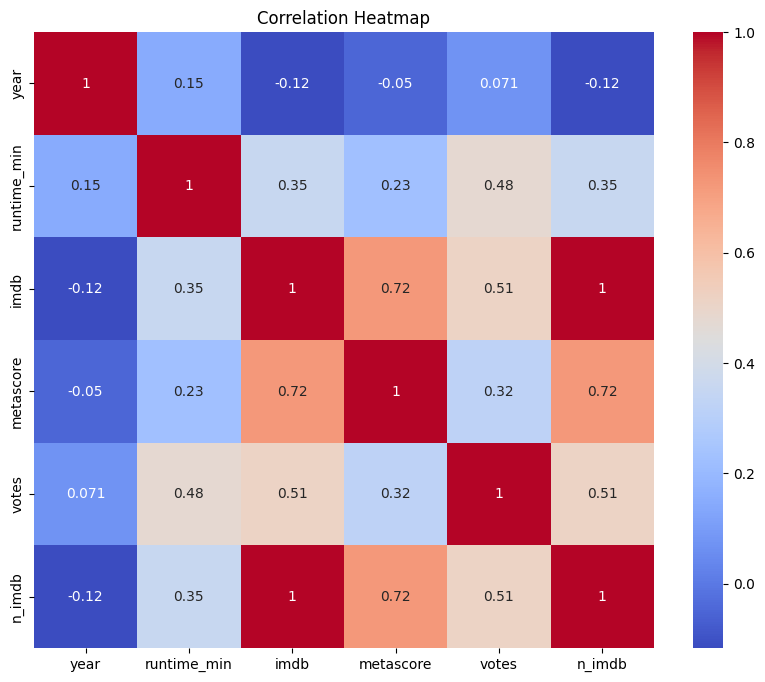

In [11]:
import pandas as pd
import seaborn as sns  # Import Seaborn
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Assuming you have already cleaned and formatted your DataFrame 'final_df'

# Create a correlation matrix
corr_matrix = final_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


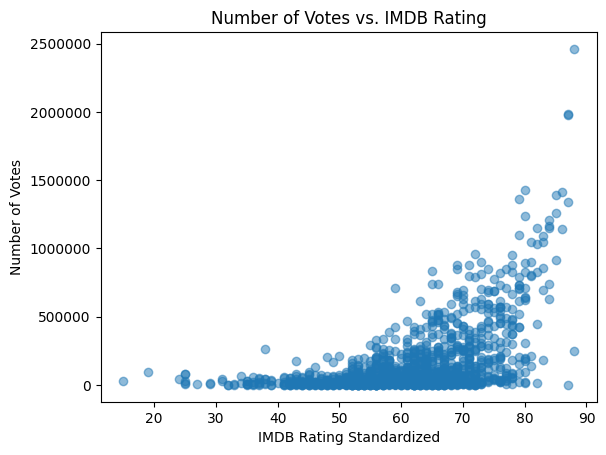

In [12]:
x = final_df['n_imdb']
y = final_df['votes']
plt.scatter(x, y, alpha=0.5) # s= is size var, c= is color var
plt.xlabel("IMDB Rating Standardized")
plt.ylabel("Number of Votes")
plt.title("Number of Votes vs. IMDB Rating")
plt.ticklabel_format(style='plain')
plt.show()

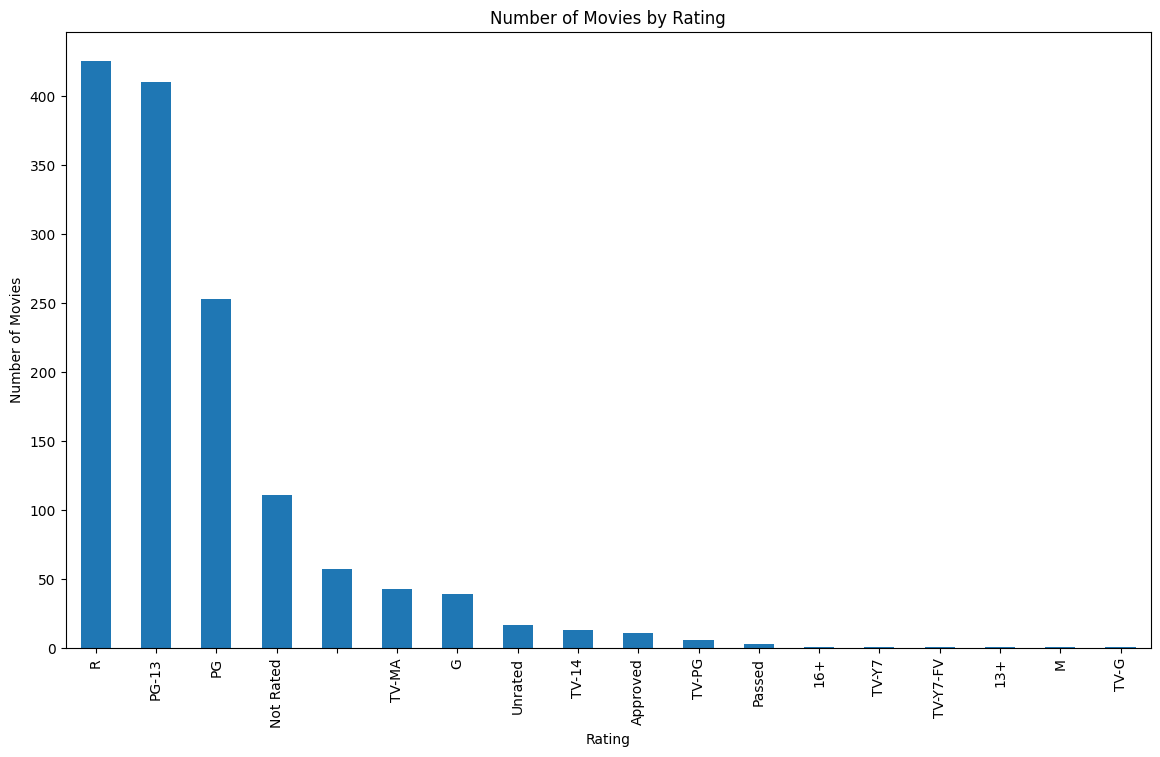

In [13]:
ax = final_df['rating'].value_counts().plot(kind='bar',
                                   figsize=(14,8),
                                   title="Number of Movies by Rating")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Movies")
ax.plot();

In [14]:
final_df[final_df['rating'] == 'Approved']

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
276,Barbarella,1968.0,Approved,"[Adventure, Comedy, Fantasy]",98,5.8,51,36699,58.0
604,Rollerball,1975.0,Approved,"[Action, Sci-Fi, Sport]",125,6.6,56,27556,66.0
708,The Blob,1958.0,Approved,"[Horror, Sci-Fi]",86,6.3,58,28244,63.0
790,Invasion of the Body Snatchers,1956.0,Approved,"[Drama, Horror, Sci-Fi]",80,7.7,92,52858,77.0
885,On the Beach,1959.0,Approved,"[Drama, Romance, Sci-Fi]",134,7.1,55,14009,71.0
1016,Demon Seed,1977.0,Approved,"[Horror, Sci-Fi]",94,6.3,55,9650,63.0
1095,The Absent Minded Professor,1961.0,Approved,"[Comedy, Family, Sci-Fi]",92,6.7,75,8938,67.0
1137,The Curse of Frankenstein,1957.0,Approved,"[Horror, Sci-Fi, Thriller]",82,7.0,59,12056,70.0
1150,The Damned,1962.0,Approved,"[Drama, Fantasy, Horror]",87,6.6,72,3812,66.0
1237,Mighty Joe Young,1949.0,Approved,"[Adventure, Drama, Fantasy]",94,7.0,61,5555,70.0


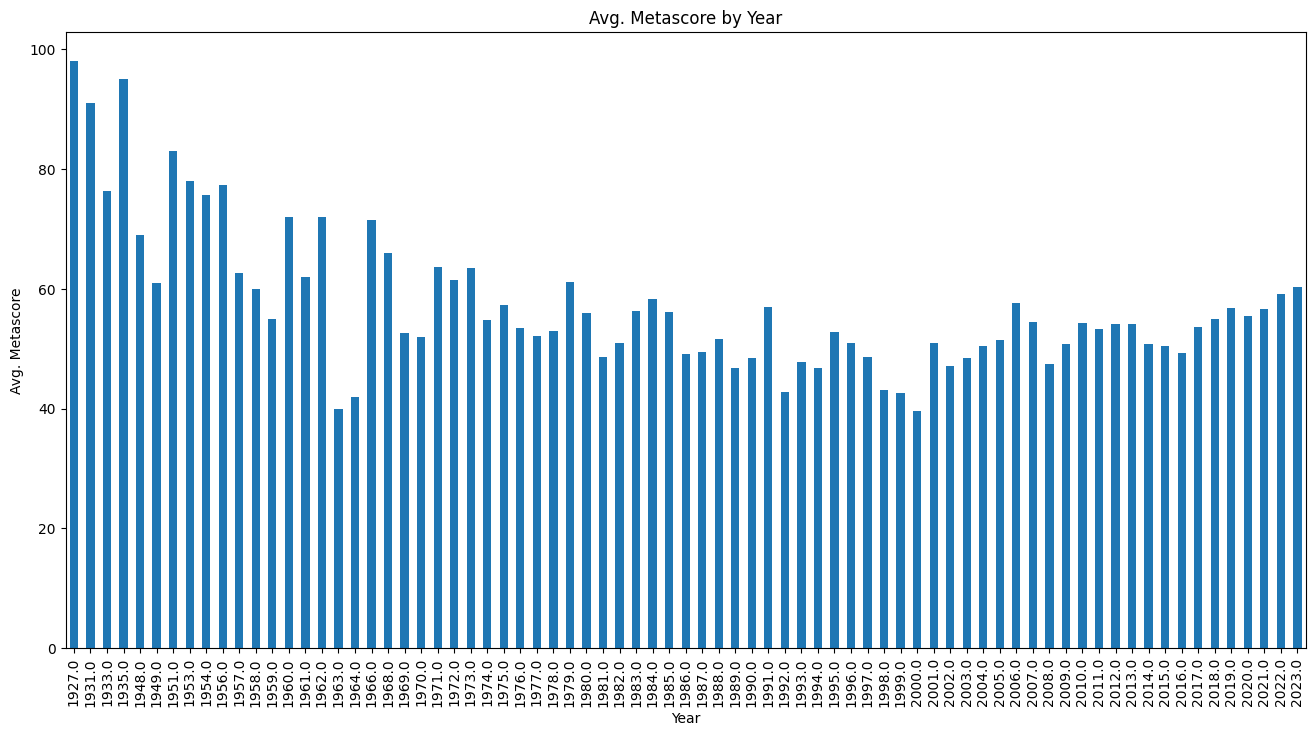

In [15]:
# What are the average metascores by year?
final_df.groupby('year')['metascore'].mean().plot(kind='bar', figsize=(16,8), title="Avg. Metascore by Year", xlabel="Year", ylabel="Avg. Metascore")
plt.xticks(rotation=90)
plt.plot();

<Axes: >

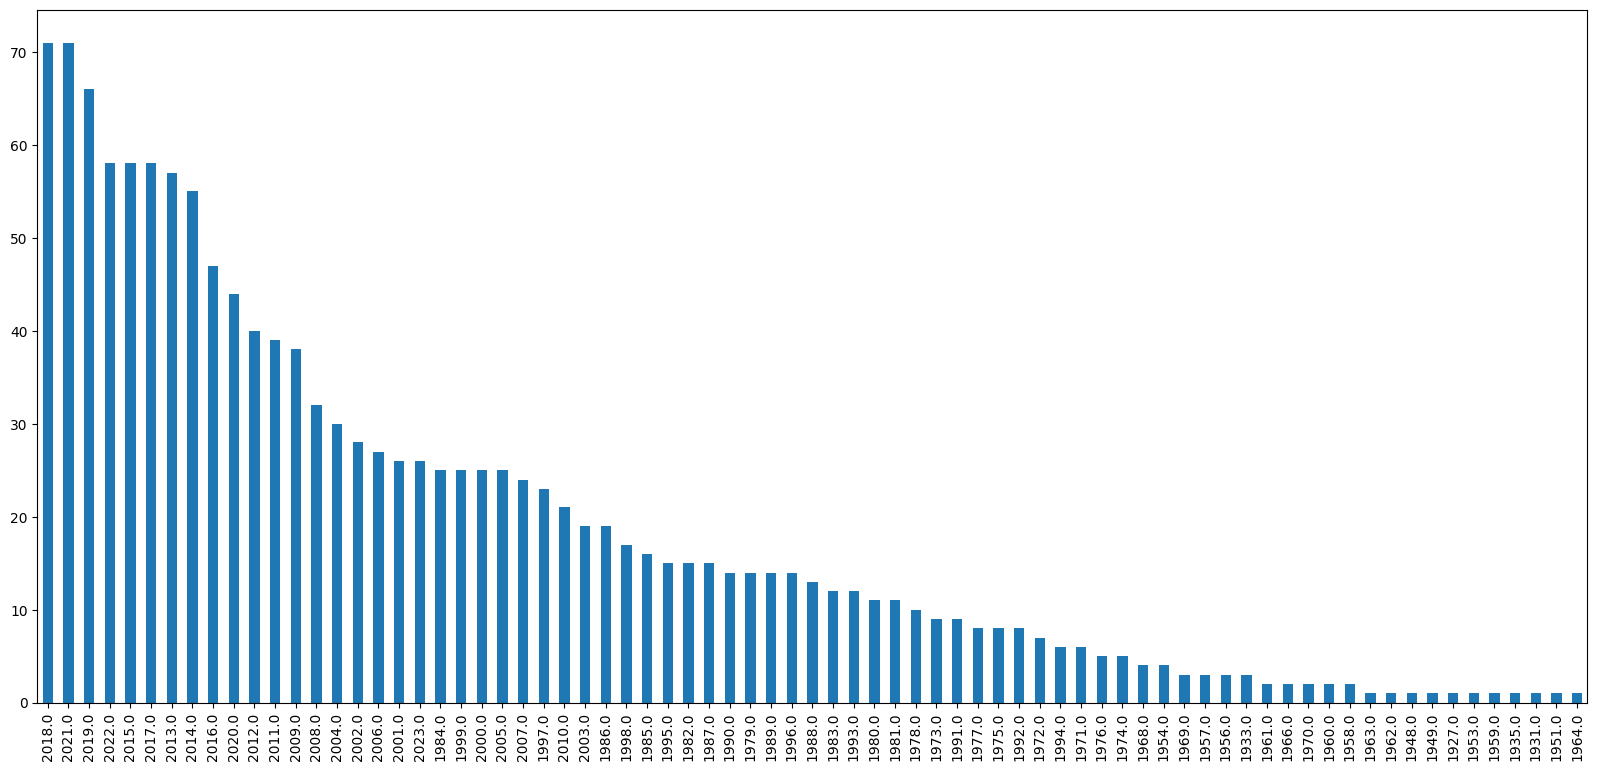

In [16]:
final_df['year'].value_counts().plot(kind='bar', figsize=[20,9])